In [1]:
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory
time_window=10000 # you can chose how long do you want to visualize the data
exp = 'EFRCourierOpenLoop'
subject = 'R1620J' 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import glob
import cmlreaders as cml
import json
from matplotlib.ticker import FuncFormatter
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy import stats

def add_phase_column(evs):
    """Add phase column to events DataFrame"""
    evs["phase"] = 1
    new_evs = pd.DataFrame()  # Initialize as DataFrame, not list
    for ind, list_evs in evs.groupby('trial'):  # 'trial' is the equivalent of a delivery day
        list_evs = list_evs.copy()  # Avoid SettingWithCopyWarning
        if list_evs['trial'].unique()[0] != -999:
            list_evs['phase'] = 'nan'
            if not list_evs[list_evs['type'] == 'TRIAL_START'].index.empty and not list_evs[list_evs['type'] == 'TRIAL_END'].index.empty:
                # find indexes of encoding start and end
                rec_start_indices = list_evs[list_evs['type'] == 'REC_START'].index
                if not rec_start_indices.empty:
                    rec_start_index = rec_start_indices[0]
                    start_time = list_evs.loc[rec_start_index]['eegoffset']
                    # Find the actual start index based on time condition
                    i = 0
                    rec_start_index_found = True
                    actual_start_index = rec_start_index  # Initialize with default
                    
                    while rec_start_index_found:
                        current_idx = rec_start_index + i
                          #print(i)
                        # Check bounds for iloc access
                        check_time = evs.iloc[current_idx]['eegoffset']  # Use relative index i
                        if check_time - start_time < 3000:
                            i += 1
                            #print(check_time - start_time)
                        else:
                            rec_start_index_found = False
                            actual_start_index = rec_start_index+i
                            #print(i)# Get actual index from list_evs
                    rec_end_indices = list_evs[list_evs['type'] == 'REC_STOP'].index
                    if not rec_end_indices.empty:
                        rec_end_index = rec_end_indices[0]
                        # Now assign to original evs DataFrame using the original indices
                        evs.loc[actual_start_index:rec_end_index, 'phase'] = 'retrieval'
                        #print('get one value', actual_start_index,rec_end_index)
    return evs

# Get the full data index
whole_df = cml.CMLReader.get_data_index()

# Define the experiment
exp = 'EFRCourierOpenLoop'

# Get unique subjects for the experiment
subjects = whole_df.query('experiment == @exp')['subject'].unique()
subjects=['R1620J', 'R1653J', 'R1693J',
       'R1709J', 'R1724J']
# Initialize results storage
results = []

# Loop through each subject
for subject in subjects:
  #  print(f"Processing subject: {subject}")
    
    # Get subject data
    sub_df = whole_df.query('experiment == @exp and subject == @subject')
    
    # Get all sessions for this subject
    sessions = sub_df['session'].unique()
    
    # Loop through each session
    for session in sessions:
     #    print(f"  Processing session: {session}")
        
        try:
            # Create reader for this subject and session
            reader = cml.CMLReader(subject, exp, session=session)
            evs = reader.load('task_events')
            
            # Add the phase column
            evs = add_phase_column(evs)
            
            # Add the inside_stimuli variable
            evs['inside_stimuli'] = -999
            stimuli_indices = evs[evs['type'] == 'STIM'].index
            
            for i in stimuli_indices:
                current_offset = evs.loc[i, 'eegoffset']
                evs.loc[i, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
                # Keep checking subsequent rows until difference >= 3000
                j = i+1
                rows_to_assign = []  # Store indices of rows to assign
                
                while j < len(evs):
                    next_offset = evs.loc[j, 'eegoffset']
                    time_diff = abs(next_offset - current_offset)
                    #print(time_diff)
                    if time_diff < 3000:
                        # Still within 3 seconds, add this row to assignment list
                        rows_to_assign.append(j)
                        j += 1
                    else:
                        # Found a row with difference >= 4000, stop checking
                        break
                
                # Assign burst_freq to all rows that were within 4000ms of the STIM
                for row_idx in rows_to_assign:
                    evs.loc[row_idx, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
                    evs.loc[i, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            # Get unique trials for this session
            trials = evs['trial'].unique()
# Find indices of all WORD events
            word_indices = evs[evs['type'] == "WORD"].index

            # Get the events immediately before WORD events
            preceding_events = evs.iloc[word_indices - 1]

            # Find which preceding events are STIM type
            stim_mask = preceding_events['type'] == 'STIM'
            stim_indices = preceding_events[stim_mask].index

            # Update the inside_stimuli column for WORD events that follow STIM events
            for stim_idx in stim_indices:
                word_idx = stim_idx + 1
                burst_freq = evs.loc[stim_idx, 'stim_params']['burst_freq']
                evs.loc[word_idx, 'inside_stimuli'] = burst_freq
                evs.loc[stim_idx, 'inside_stimuli'] = burst_freq
            # Loop through each trial
            for trial in trials:
                if trial != -999 and trial >= 0:  # Skip invalid trials   if trial != -999 and trial >= 0:
                   # print(f"    Processing trial: {trial}")
                    
                    # Filter events for this specific trial
                    trial_evs = evs[evs['trial'] == trial]
                    
                    # Filter for intrusions with additional conditions for this trial
                    intrusion_events = trial_evs[((trial_evs['intrusion'] > 0) | (trial_evs['intrusion'] == -1)) & 
                                                (trial_evs['type'] == 'REC_WORD') & 
                                                (trial_evs['phase'] == 'retrieval')]
                    none_intrusion_events = trial_evs[(trial_evs['intrusion'] == 0) & 
                                                     (trial_evs['type'] == 'REC_WORD') & 
                                                     (trial_evs['phase'] == 'retrieval')]
                    retrieval_phase_events=trial_evs[(trial_evs['phase'] == 'retrieval')]
                    encoding_phase_events=trial_evs[(trial_evs['phase'] != 'retrieval')]
                    # Count intrusions for each stimulation condition
                    intrusion_count_3hz = (intrusion_events['inside_stimuli'] == 3).sum()
                    intrusion_count_8hz = (intrusion_events['inside_stimuli'] == 8).sum()
                    intrusion_count_no_stim = (intrusion_events['inside_stimuli'] == -999).sum()
                    intrusion_count_total = len(intrusion_events)
                    stimi_retrieval_count_3hz = ((retrieval_phase_events['inside_stimuli'] == 3)&(trial_evs['type'] == 'STIM')).sum()
                    stimi_encoding_count_3hz = ((encoding_phase_events['inside_stimuli'] == 3)&(trial_evs['type'] == 'STIM')).sum()
                    stimi_retrieval_count_8hz = ((retrieval_phase_events['inside_stimuli'] == 8)&(trial_evs['type'] == 'STIM')).sum()
                    stimi_encoding_count_8hz = ((encoding_phase_events['inside_stimuli'] == 8)&(trial_evs['type'] == 'STIM')).sum()
                    # Count none intrusions for each stimulation condition
                    none_intrusion_count_3hz = (none_intrusion_events['inside_stimuli'] == 3).sum()
                    none_intrusion_count_8hz = (none_intrusion_events['inside_stimuli'] == 8).sum()
                    none_intrusion_count_no_stim = (none_intrusion_events['inside_stimuli'] == -999).sum()
                    none_intrusion_count_total = len(none_intrusion_events)
                  #  print(none_intrusion_events[['item','inside_stimuli']])
                    DuringSTIM_no=none_intrusion_events['inside_stimuli']==-999
                    No_stimuli_item=none_intrusion_events[DuringSTIM_no]['item']
                    DuringSTIM_yes=(none_intrusion_events['inside_stimuli']==3)|(none_intrusion_events['inside_stimuli']==8)
                    With_stimuli_item=none_intrusion_events[DuringSTIM_yes]['item']
                    Encode_withStimulation_item=trial_evs[(trial_evs['type']=='WORD') & ( (trial_evs['inside_stimuli']==3)| (trial_evs['inside_stimuli']==8))]['item']
                    Encode_without_Stimulation_item=trial_evs[(trial_evs['type']=='WORD') & (trial_evs['inside_stimuli']==-999)]['item']
                    # Convert to sets for efficient intersection operations
                    with_stimuli_set = set(With_stimuli_item)
                    encode_with_stim_set = set(Encode_withStimulation_item)
                    encode_without_stim_set = set(Encode_without_Stimulation_item)
                    no_stimuli_set = set(No_stimuli_item)

                    # Calculate overlaps for With_stimuli_item
                    with_stim_from_encode_with = len(with_stimuli_set.intersection(encode_with_stim_set))
                    with_stim_from_encode_without = len(with_stimuli_set.intersection(encode_without_stim_set))

                    # Calculate overlaps for No_stimuli_item  
                    no_stim_from_encode_with = len(no_stimuli_set.intersection(encode_with_stim_set))
                    no_stim_from_encode_without = len(no_stimuli_set.intersection(encode_without_stim_set))
                    # Store results for this trial
                    trial_result = {
                                'subject': subject,
                                'session': session,
                                'trial': trial,
                                'intrusion_count_3hz': intrusion_count_3hz if  (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'intrusion_count_8hz': intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'intrusion_count_no_stim': intrusion_count_no_stim,
                                'intrusion_count_total': intrusion_count_total,
                                'recall_3hz': none_intrusion_count_3hz if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'recall_8hz': none_intrusion_count_8hz if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'recall_no_stim': none_intrusion_count_no_stim,
                                'none_intrusion_count_total': none_intrusion_count_total,
                                'encode_STIM_retrival_STIM_8hz':with_stim_from_encode_with if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_No_retrival_STIM_8hz':with_stim_from_encode_without if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_STIM_retrival_No_8hz':no_stim_from_encode_with if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_No_retrival_No_8hz':no_stim_from_encode_without if (trial_evs['inside_stimuli'] == 8).sum() !=0 else None,
                                'encode_STIM_retrival_STIM_3hz':with_stim_from_encode_with if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'encode_No_retrival_STIM_3hz':with_stim_from_encode_without if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'encode_STIM_retrival_No_3hz':no_stim_from_encode_with if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'encode_No_retrival_No_3hz':no_stim_from_encode_without if (trial_evs['inside_stimuli'] == 3).sum() !=0 else None,
                                'stimi_retrieval_count_3hz':stimi_retrieval_count_3hz,
                                'stimi_retrieval_count_8hz':stimi_retrieval_count_8hz,
                                'stimi_encoding_count_3hz':stimi_encoding_count_3hz,
                                'stimi_encoding_count_8hz':stimi_encoding_count_8hz,
                        
                        
                            }
                    results.append(trial_result)
                    
                  #  print(f"      Trial {trial} - Intrusions - 3Hz: {intrusion_count_3hz}, 8Hz: {intrusion_count_8hz}, No stim: {intrusion_count_no_stim}, Total: {intrusion_count_total}")
            
        except Exception as e:
          #  print(f"    Error processing session {session}: {str(e)}")
            continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display summary statistics
print("\n" + "="*50)
print("INTRUSION ANALYSIS SUMMARY (BY TRIAL)")
print("="*50)

if len(results_df) > 0:
    print(f"Total subjects processed: {results_df['subject'].nunique()}")
    print(f"Total sessions processed: {results_df['session'].nunique()}")
    print(f"Total trials processed: {len(results_df)}")
    print(f"\nIntrusion statistics across all trials:")
    print(f"Mean intrusions per trial:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].mean():.3f} ± {results_df['intrusion_count_3hz'].std():.3f}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].mean():.3f} ± {results_df['intrusion_count_8hz'].std():.3f}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].mean():.3f} ± {results_df['intrusion_count_no_stim'].std():.3f}")
    print(f"  Total: {results_df['intrusion_count_total'].mean():.3f} ± {results_df['intrusion_count_total'].std():.3f}")
    print(f"\nTotal intrusions across all trials:")
    print(f"  3Hz stimulation: {results_df['intrusion_count_3hz'].sum()}")
    print(f"  8Hz stimulation: {results_df['intrusion_count_8hz'].sum()}")
    print(f"  No stimulation: {results_df['intrusion_count_no_stim'].sum()}")
    print(f"  Total: {results_df['intrusion_count_total'].sum()}")
    
    # Display the results DataFrame
    print(f"\nDetailed results:")
  



INTRUSION ANALYSIS SUMMARY (BY TRIAL)
Total subjects processed: 5
Total sessions processed: 5
Total trials processed: 41

Intrusion statistics across all trials:
Mean intrusions per trial:
  3Hz stimulation: 0.800 ± 1.196
  8Hz stimulation: 0.409 ± 0.590
  No stimulation: 0.341 ± 0.617
  Total: 0.951 ± 1.244

Total intrusions across all trials:
  3Hz stimulation: 16.0
  8Hz stimulation: 9.0
  No stimulation: 14
  Total: 39

Detailed results:


In [2]:
pd.set_option('display.max_rows', None)
print(results_df['stimi_encoding_count_8hz'].sum())
print(results_df['stimi_encoding_count_3hz'].sum())
print(results_df['stimi_retrieval_count_3hz'].sum())
print(results_df['stimi_retrieval_count_8hz'].sum())
len(results_df)

176
177
285
270


41

In [4]:
# Step 1: Create the original dataset

data_long = pd.melt(results_df, 
                   id_vars=['subject', 'session','trial'], 
                   value_vars=['recall_no_stim', 'recall_3hz', 'recall_8hz'],
                   var_name='condition', 
                   value_name='recall_performance')




# Create dummy variables for conditions (with no_stim as reference)
data_long['condition_3hz'] = (data_long['condition'] == 'recall_3hz').astype(int)
data_long['condition_8hz'] = (data_long['condition'] == 'recall_8hz').astype(int)

# Convert subject to string to ensure proper grouping
data_long['subject'] = data_long['subject'].astype(str)
data_long['session'] = data_long['session'].astype(str)
data_long = data_long.dropna(subset=['recall_performance'])
model1 = mixedlm("recall_performance ~ condition_3hz + condition_8hz", 
                 data_long, 
                 groups=data_long["subject"],
                 re_formula="1",
                 vc_formula={"session": "0 + C(session)",
                            "trial": "0 + C(trial)"})

result = model1.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: recall_performance
No. Observations: 83      Method:             REML              
No. Groups:       5       Scale:              1.7999            
Min. group size:  8       Log-Likelihood:     -153.9314         
Max. group size:  28      Converged:          Yes               
Mean group size:  16.6                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          1.524     0.349   4.365  0.000   0.840   2.208
condition_3hz      0.676     0.376   1.796  0.073  -0.062   1.414
condition_8hz     -0.211     0.363  -0.581  0.561  -0.921   0.500
Group Var          0.111     0.308                               
session Var        0.167     0.238                               
trial Var          0.767     0.

In [8]:
results_df['delta_3hz']=results_df['recall_3hz']-results_df['recall_no_stim']
results_df['delta_8hz']=results_df['recall_8hz']-results_df['recall_no_stim']
filtered_df = results_df[results_df['delta_3hz'].notna()]
summary_stats_3hz= results_df.groupby(['subject'])['delta_3hz'].mean().reset_index()
filtered_df = results_df[results_df['delta_8hz'].notna()]
summary_stats_8hz=results_df.groupby(['subject'])['delta_8hz'].mean().reset_index()


Difference Score Summary Statistics:
          condition    mean     std     sem  count  ci_lower  ci_upper
0  3Hz - No Stimuli  0.8762  0.8849  0.3957      5    0.1006    1.6518
1  8Hz - No Stimuli -0.0833  0.8858  0.3962      5   -0.8598    0.6931


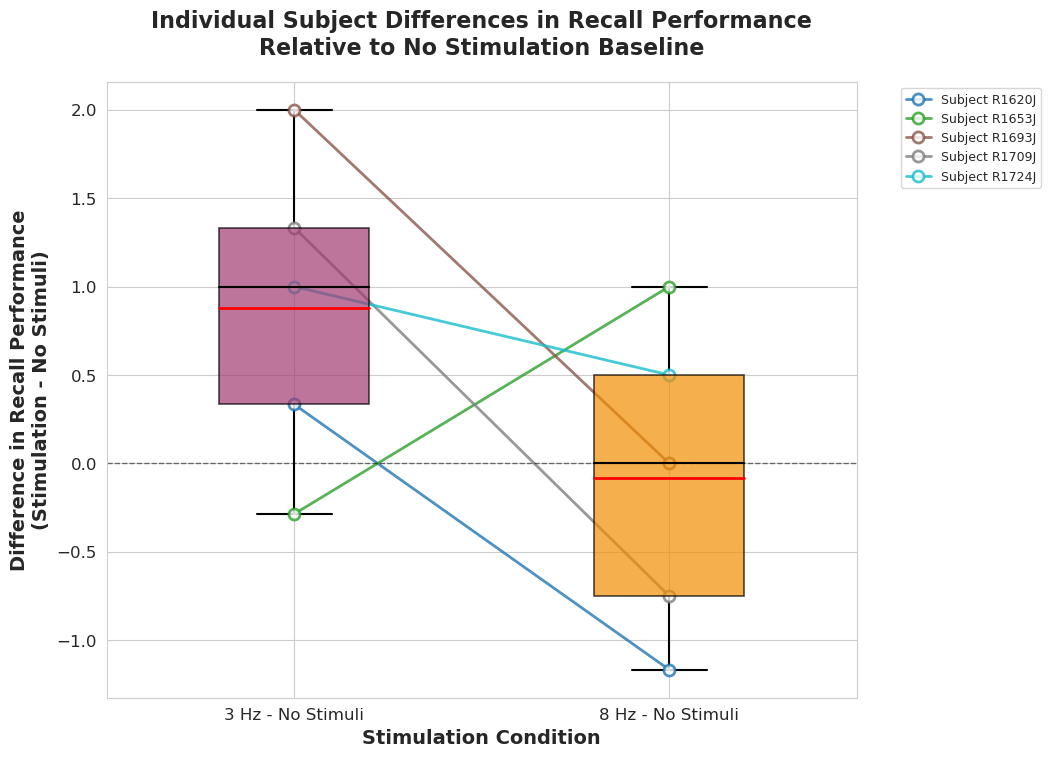

In [9]:
data_long['condition_clean'] = data_long['condition'].map({
    'recall_no_stim': 'No Stimuli',
    'recall_3hz': '3 Hz',
    'recall_8hz': '8 Hz'
})

# Calculate means across sessions and participants for each condition
summary_stats = data_long.groupby(['subject', 'condition_clean'])['recall_performance'].mean().reset_index()

# Pivot data to have subjects as rows and conditions as columns
participant_pivot = summary_stats.pivot(index='subject', columns='condition_clean', values='recall_performance')
participant_pivot = participant_pivot[['No Stimuli', '3 Hz', '8 Hz']]  # Ensure correct order

# Calculate difference scores for each subject
difference_data = pd.DataFrame({
    'subject': participant_pivot.index,
    '3Hz - No Stimuli':summary_stats_3hz['delta_3hz'],
    '8Hz - No Stimuli': summary_stats_8hz['delta_8hz']
})

# Remove subjects with missing data


# Calculate summary statistics for difference scores
diff_summary = pd.DataFrame({
    'condition': ['3Hz - No Stimuli', '8Hz - No Stimuli'],
    'mean': [summary_stats_3hz['delta_3hz'].mean(), summary_stats_8hz['delta_8hz'].mean()],
    'std': [summary_stats_3hz['delta_3hz'].std(),summary_stats_8hz['delta_8hz'].std()],
    'sem': [summary_stats_3hz['delta_3hz'].sem(), summary_stats_8hz['delta_8hz'].sem()],
    'count': [len(summary_stats_3hz['delta_3hz']), len(summary_stats_8hz['delta_8hz'])]
})

# Calculate 95% confidence intervals
diff_summary['ci_lower'] = diff_summary['mean'] - 1.96 * diff_summary['sem']
diff_summary['ci_upper'] = diff_summary['mean'] + 1.96 * diff_summary['sem']

print("Difference Score Summary Statistics:")
print(diff_summary.round(4))

# Create the plot with larger size to accommodate legend
plt.figure(figsize=(12, 8))

# Set up the plot style
sns.set_style("whitegrid")
colors = ['#A23B72', '#F18F01']  # Purple for 3Hz, Orange for 8Hz

# Prepare data for box plot
box_data = [difference_data['3Hz - No Stimuli'].values, difference_data['8Hz - No Stimuli'].values]

# Create box plot for difference scores
x_pos = [0, 1]
box_plot = plt.boxplot(box_data, 
                       positions=x_pos,
                       patch_artist=True,
                       widths=0.4,
                       showmeans=True,
                       meanline=True)

# Customize box plot colors
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.2)

# Customize other box plot elements
for element in ['whiskers', 'caps', 'medians']:
    for item in box_plot[element]:
        item.set_color('black')
        item.set_linewidth(1.5)

# Customize mean lines
for item in box_plot['means']:
    item.set_color('red')
    item.set_linewidth(2)
    item.set_linestyle('-')

# Generate distinct colors for each subject
n_subjects = len(difference_data)
if n_subjects <= 10:
    colors_subjects = plt.cm.tab10(np.linspace(0, 1, n_subjects))
elif n_subjects <= 20:
    colors_subjects = plt.cm.tab20(np.linspace(0, 1, n_subjects))
else:
    colors_subjects = plt.cm.viridis(np.linspace(0, 1, n_subjects))

# Plot lines connecting each participant's difference scores
for idx, (_, row) in enumerate(difference_data.iterrows()):
    subject_id = row['subject']
    diff_3hz = row['3Hz - No Stimuli']
    diff_8hz = row['8Hz - No Stimuli']
    
    plt.plot([0, 1], [diff_3hz, diff_8hz], 
             color=colors_subjects[idx], 
             alpha=0.8, 
             linewidth=2,
             marker='o',
             markersize=8,
             markerfacecolor='white',
             markeredgecolor=colors_subjects[idx],
             markeredgewidth=2,
             zorder=2,
             label=f'Subject {subject_id}')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Customize the plot
plt.ylabel('Difference in Recall Performance\n(Stimulation - No Stimuli)', fontsize=14, fontweight='bold')
plt.xlabel('Stimulation Condition', fontsize=14, fontweight='bold')
plt.title('Individual Subject Differences in Recall Performance\nRelative to No Stimulation Baseline', 
          fontsize=16, fontweight='bold', pad=20)

# Set x-axis labels
plt.xticks(x_pos, ['3 Hz - No Stimuli', '8 Hz - No Stimuli'], fontsize=12)
plt.yticks(fontsize=12)

# Add value labels showing means


# Add legend for subjects
if n_subjects <= 15:  # Only add legend if not too many subjects
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.subplots_adjust(right=0.75)  # Make room for legend
else:
    # For many subjects, add a note instead of cluttered legend
    plt.figtext(0.02, 0.95, f'Each colored line represents one of {n_subjects} subjects', 
                fontsize=10, style='italic')
    plt.tight_layout()


plt.show()

In [193]:
colors_subjects

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]])

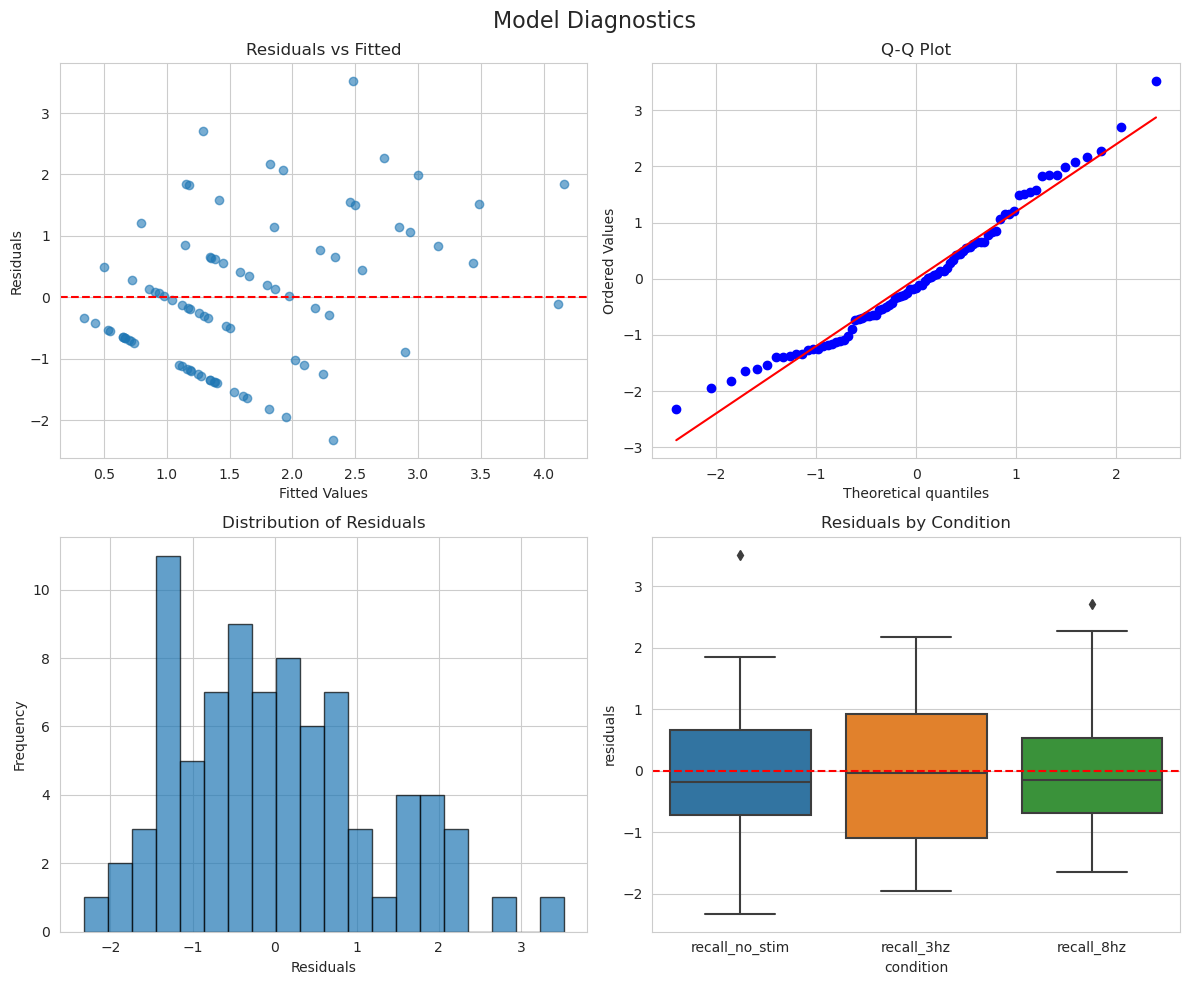

In [11]:
fitted_values = result.fittedvalues
residuals = result.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Diagnostics', fontsize=16)

# 1. Residuals vs Fitted
axes[0,0].scatter(fitted_values, residuals, alpha=0.6)
axes[0,0].axhline(y=0, color='r', linestyle='--')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted')

# 2. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot')

# 3. Histogram of residuals
axes[1,0].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Residuals')

# 4. Residuals by condition
data_with_resid = data_long.copy()
data_with_resid['residuals'] = residuals

sns.boxplot(data=data_with_resid, x='condition', y='residuals', ax=axes[1,1])
axes[1,1].set_title('Residuals by Condition')
axes[1,1].axhline(y=0, color='r', linestyle='--')
plt.savefig("ModelDisagnostics_rate_during_Encoding.pdf", 
           transparent=True,      # Transparent background
           bbox_inches='tight',   # Removes extra whitespace
           pad_inches=0.08,       # Small padding around the figure
           format='pdf')   
plt.tight_layout()
plt.show()


In [220]:
data_long['subject_in_group'] = data_long['session'].astype(str) + '_' + data_long['subject'].astype(str)

model1 = mixedlm("recall_performance ~ condition_3hz + condition_8hz", 
                 data_long, 
                 groups=data_long["subject"],  # Higher level
                 re_formula="1",
                 vc_formula={"session": "0 + C(session)"}) 
result = model1.fit()
print(result.summary())

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: recall_performance
No. Observations: 83      Method:             REML              
No. Groups:       5       Scale:              2.4095            
Min. group size:  8       Log-Likelihood:     -156.9833         
Max. group size:  28      Converged:          No                
Mean group size:  16.6                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          1.512     0.372   4.068  0.000   0.783   2.240
condition_3hz      0.629     0.426   1.478  0.139  -0.205   1.464
condition_8hz     -0.265     0.411  -0.646  0.518  -1.071   0.540
Group Var          0.305     0.345                               
session Var        0.139     0.266                               



/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2118: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2130: ConvergenceWarning: Gradient optimization failed, |grad| = 1.496605
  warnings.warn(msg, ConvergenceWarning)



Summary statistics by subject:
         count    mean     std
subject                       
R1620J      22  2.2273  1.7977
R1653J      28  1.2500  1.2360
R1693J      11  0.5455  1.2136
R1709J      14  2.2143  1.9287
R1724J       8  1.6250  1.9226


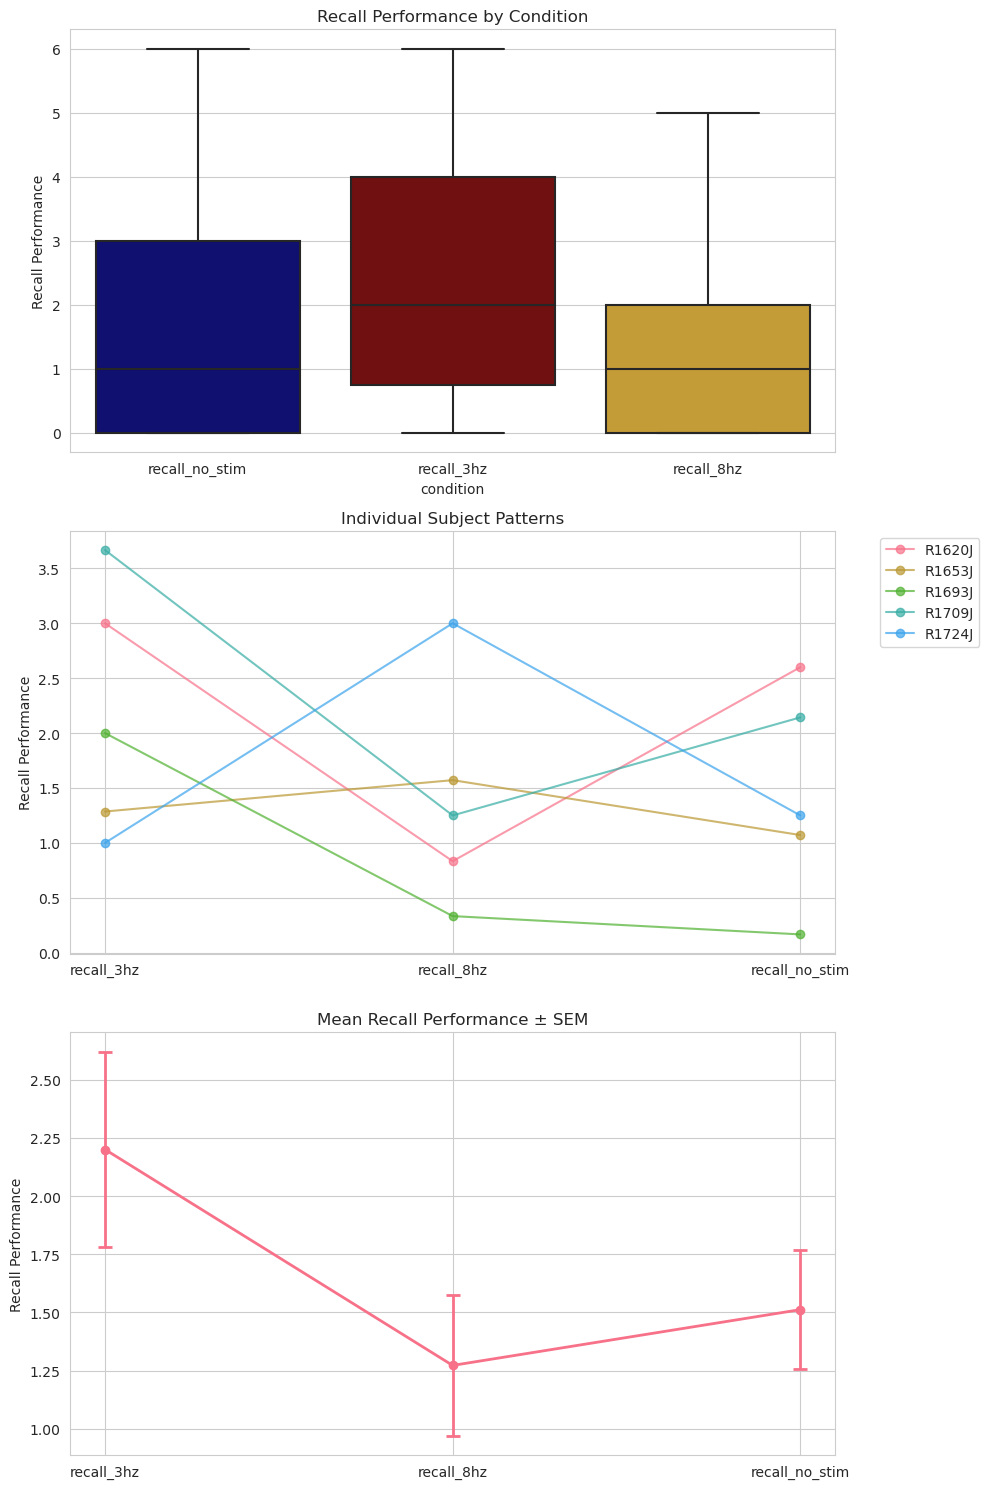

In [221]:
subject_stats = data_long.groupby('subject')['recall_performance'].agg([
    'count', 'mean', 'std'
]).round(4)
print("\nSummary statistics by subject:")
print(subject_stats)
colors = ['Navy', 'maroon', 'goldenrod']
# Step 4: Visualization
plt.figure(figsize=(10, 15))

# Subplot 1: Box plot by condition
plt.subplot(3, 1, 1)
sns.boxplot(data=data_long, x='condition', y='recall_performance',palette=colors)
plt.title('Recall Performance by Condition')
plt.ylabel('Recall Performance')

# Subplot 2: Individual subject trajectories
plt.subplot(3, 1, 2)
for subject in data_long['subject'].unique():
    subject_data = data_long[data_long['subject'] == subject]
    condition_means = subject_data.groupby('condition')['recall_performance'].mean()
    plt.plot(range(len(condition_means)), condition_means.values, 'o-', alpha=0.7, label=subject)
plt.xticks(range(3), condition_means.index)
plt.title('Individual Subject Patterns')
plt.ylabel('Recall Performance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Subplot 3: Mean with error bars
plt.subplot(3, 1, 3)
condition_summary = data_long.groupby('condition')['recall_performance'].agg(['mean', 'sem'])
plt.errorbar(range(len(condition_summary)), 
            condition_summary['mean'], 
            yerr=condition_summary['sem'], 
            marker='o', capsize=5, capthick=2, linewidth=2)
plt.xticks(range(3),  condition_means.index)
plt.title('Mean Recall Performance ± SEM')
plt.ylabel('Recall Performance')

plt.tight_layout()
plt.show()


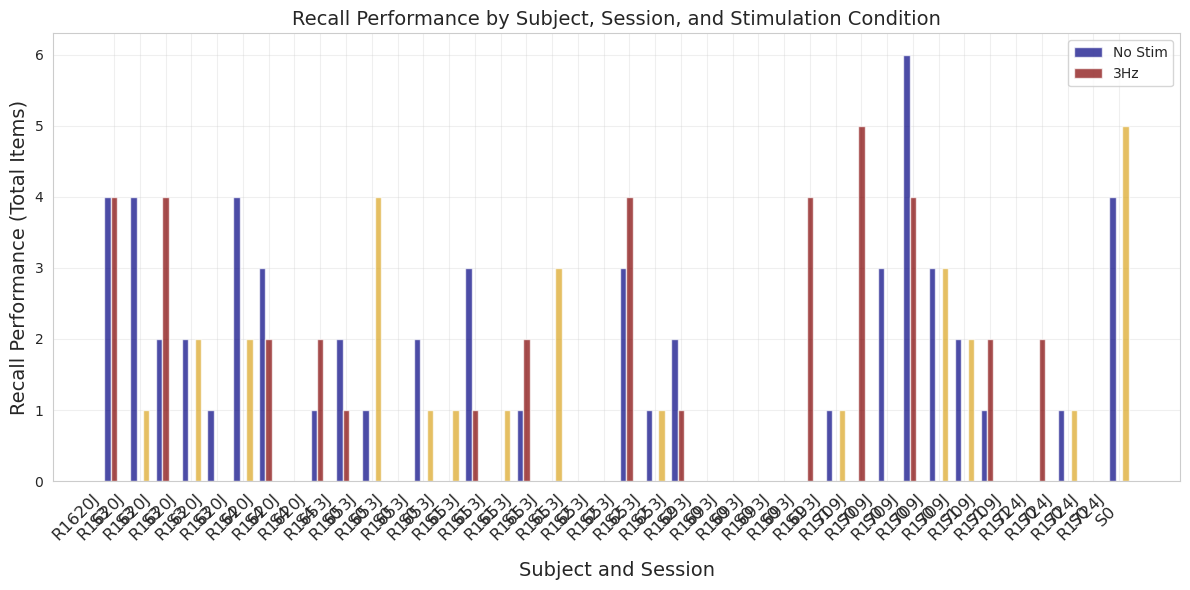

Summary Statistics:
Total subjects: 5
Total sessions: 40

Sessions with each condition:
No Stimulation: 40 sessions
3Hz Stimulation: 19 sessions
8Hz Stimulation: 22 sessions

Mean recall performance (only sessions where condition was present):
No Stimulation: 1.43 ± 1.57
3Hz Stimulation: 2.00 ± 1.70
8Hz Stimulation: 1.27 ± 1.42


In [224]:

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique subjects
subjects = df_filtered['subject'].unique()
x_positions = []
labels = []

# Plot data for each subject and session
x_pos = 0
for subject in subjects:
    subject_data = df_filtered[df_filtered['subject'] == subject]
    
    for _, row in subject_data.iterrows():
        # Handle values: NaN = condition not present (don't plot), 0 = no recalls (plot as 0)
        no_stim_val = row['recall_no_stim'] if pd.notna(row['recall_no_stim']) else None
        hz3_val = row['recall_3hz'] if pd.notna(row['recall_3hz']) else None
        hz8_val = row['recall_8hz'] if pd.notna(row['recall_8hz']) else None
        hz3_val_ralative = row['relative_3hz'] if pd.notna(row['relative_3hz']) else None
        hz8_vall_ralative = row['relative_8hz'] if pd.notna(row['relative_8hz']) else None

        
        # Only plot bars for conditions that were actually present (not NaN)
        if no_stim_val is not None:
            ax.bar(x_pos - 0.25, no_stim_val, width=0.25, 
                   label='No Stim' if x_pos == 0 else "", color='Navy', alpha=0.7)
        
        if hz3_val is not None:
            ax.bar(x_pos, hz3_val, width=0.25, 
                   label='3Hz' if x_pos == 0 else "", color='maroon', alpha=0.7)
        
        if hz8_val is not None:
            ax.bar(x_pos + 0.25, hz8_val, width=0.25, 
                   label='8Hz' if x_pos == 0 else "", color='goldenrod', alpha=0.7)
        
        # Store position and label
        x_positions.append(x_pos)
        labels.append(f"{subject}\nS{int(row['session'])}")
        
        x_pos += 1

# Customize the plot
ax.set_xlabel('Subject and Session', fontsize=14)
ax.set_ylabel('Recall Performance (Total Items)', fontsize=14)
ax.set_title('Recall Performance by Subject, Session, and Stimulation Condition', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("recall_performance_by_stimulation.pdf", 
           transparent=True,      # Transparent background
           bbox_inches='tight',   # Removes extra whitespace
           pad_inches=0.08,       # Small padding around the figure
           format='pdf')    
plt.show()

# Print summary statistics (handling NaN vs 0 properly)
print("Summary Statistics:")
print(f"Total subjects: {df_filtered['subject'].nunique()}")
print(f"Total sessions: {len(df_filtered)}")

print("\nSessions with each condition:")
print(f"No Stimulation: {df_filtered['recall_no_stim'].notna().sum()} sessions")
print(f"3Hz Stimulation: {df_filtered['recall_3hz'].notna().sum()} sessions") 
print(f"8Hz Stimulation: {df_filtered['recall_8hz'].notna().sum()} sessions")

print("\nMean recall performance (only sessions where condition was present):")
if df_filtered['recall_no_stim'].notna().any():
    no_stim_mean = df_filtered['recall_no_stim'].mean()
    no_stim_std = df_filtered['recall_no_stim'].std()
    print(f"No Stimulation: {no_stim_mean:.2f} ± {no_stim_std:.2f}")

if df_filtered['recall_3hz'].notna().any():
    hz3_mean = df_filtered['recall_3hz'].mean()
    hz3_std = df_filtered['recall_3hz'].std()
    print(f"3Hz Stimulation: {hz3_mean:.2f} ± {hz3_std:.2f}")

if df_filtered['recall_8hz'].notna().any():
    hz8_mean = df_filtered['recall_8hz'].mean()
    hz8_std = df_filtered['recall_8hz'].std()
    print(f"8Hz Stimulation: {hz8_mean:.2f} ± {hz8_std:.2f}") #relative_recall_3hz
    

In [ ]:
# First, aggregate the trial-level data to subject/session level
# This assumes results_df is already created from your data processing code

# Aggregate data by subject and session
df_aggregated= results_df.groupby(['subject', 'session']).agg({
    'relative_recall_3hz': lambda x: np.nanmean(x) if x.notna().any() else np.nan,      
    'relative_recall_8hz': lambda x: np.nanmean(x) if x.notna().any() else np.nan,
}).reset_index()

In [ ]:
# Calculate subject-session means (handling NaN values properly)
subject_session_means = df_filtered.groupby(['subject', 'session'])[['recall_no_stim', 'recall_3hz', 'recall_8hz']].mean()

# Calculate averages across all subject-session combinations (only including sessions that had each condition)
# Use dropna to handle NaN values properly
avg_no_stim = subject_session_means['recall_no_stim'].dropna().mean()
avg_3hz = subject_session_means['recall_3hz'].dropna().mean()
avg_8hz = subject_session_means['recall_8hz'].dropna().mean()

# Calculate standard errors across subject-session combinations (only for sessions that had each condition)
n_no_stim = subject_session_means['recall_no_stim'].dropna().count()
n_3hz = subject_session_means['recall_3hz'].dropna().count()
n_8hz = subject_session_means['recall_8hz'].dropna().count()

std_no_stim = subject_session_means['recall_no_stim'].dropna().std() / np.sqrt(n_no_stim)
std_3hz = subject_session_means['recall_3hz'].dropna().std() / np.sqrt(n_3hz)
std_8hz = subject_session_means['recall_8hz'].dropna().std() / np.sqrt(n_8hz)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Only include conditions that have data
conditions = []
means = []
errors = []
colors = []

if n_no_stim > 0:
    conditions.append('No Stimulation')
    means.append(avg_no_stim)
    errors.append(std_no_stim)
    colors.append('Navy')

if n_3hz > 0:
    conditions.append('3Hz')
    means.append(avg_3hz)
    errors.append(std_3hz)
    colors.append('maroon')

if n_8hz > 0:
    conditions.append('8Hz')
    means.append(avg_8hz)
    errors.append(std_8hz)
    colors.append('goldenrod')

# Create bars and error bars
bars = ax.bar(conditions, means, color=colors, alpha=0.7, capsize=5)
ax.errorbar(conditions, means, yerr=errors, fmt='none', color='black', capsize=5)

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + errors[i] + 0.01, 
            f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=14)

# Customize the plot
ax.set_ylabel('Average Recall Performance', fontsize=14)
ax.set_title('Average Recall Performance Across Subject-Sessions', fontsize=14)
if means:  # Only set ylim if we have data
    ax.set_ylim(0, max(means) + max(errors) + 0.1)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', labelsize=16)
plt.tight_layout()

plt.savefig("Average_Recall_Performance_Across_Subject_Sessions_exclude.pdf", 
           transparent=True,      # Transparent background
           bbox_inches='tight',   # Removes extra whitespace
           pad_inches=0.08,       # Small padding around the figure
           format='pdf')    
plt.show()

# Print the exact values
print(f"Average Recall Performance/item (by subject-session means):")
if n_no_stim > 0:
    print(f"No Stimulation: {avg_no_stim:.3f} ± {std_no_stim:.3f} (n={n_no_stim} sessions)")
if n_3hz > 0:
    print(f"3Hz Stimulation: {avg_3hz:.3f} ± {std_3hz:.3f} (n={n_3hz} sessions)")
if n_8hz > 0:
    print(f"8Hz Stimulation: {avg_8hz:.3f} ± {std_8hz:.3f} (n={n_8hz} sessions)")

print(f"\nTotal subject-session combinations: {len(subject_session_means)}")
print(f"Unique subjects: {df_filtered['subject'].nunique()}")
print(f"Sessions per subject: {df_filtered.groupby('subject')['session'].nunique().tolist()}")
print("Note: Only sessions where each condition was present are included in that condition's average.")

In [ ]:
# Calculate subject means (handling NaN values properly)
subject_means = df_filtered.groupby('subject')[['recall_no_stim', 'recall_3hz', 'recall_8hz']].mean()

# Calculate averages across subjects (only including subjects who had each condition)
# Use nanmean to handle NaN values properly
avg_no_stim = subject_means['recall_no_stim'].dropna().mean()
avg_3hz = subject_means['recall_3hz'].dropna().mean()
avg_8hz = subject_means['recall_8hz'].dropna().mean()

# Calculate standard errors across subjects (only for subjects who had each condition)
n_no_stim = subject_means['recall_no_stim'].dropna().count()
n_3hz = subject_means['recall_3hz'].dropna().count()
n_8hz = subject_means['recall_8hz'].dropna().count()

std_no_stim = subject_means['recall_no_stim'].dropna().std() / np.sqrt(n_no_stim)
std_3hz = subject_means['recall_3hz'].dropna().std() / np.sqrt(n_3hz)
std_8hz = subject_means['recall_8hz'].dropna().std() / np.sqrt(n_8hz)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Only include conditions that have data
conditions = []
means = []
errors = []
colors = []

if n_no_stim > 0:
    conditions.append('No Stimulation')
    means.append(avg_no_stim)
    errors.append(std_no_stim)
    colors.append('Navy')

if n_3hz > 0:
    conditions.append('3Hz')
    means.append(avg_3hz)
    errors.append(std_3hz)
    colors.append('maroon')

if n_8hz > 0:
    conditions.append('8Hz')
    means.append(avg_8hz)
    errors.append(std_8hz)
    colors.append('goldenrod')

# Create bars and error bars
bars = ax.bar(conditions, means, color=colors, alpha=0.7, capsize=5)
ax.errorbar(conditions, means, yerr=errors, fmt='none', color='black', capsize=5)

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + errors[i] + 0.01, 
            f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=14)

# Customize the plot
ax.set_ylabel('Average Recall Performance', fontsize=14)
ax.set_title('Average Recall Performance Across Subjects', fontsize=14)
if means:  # Only set ylim if we have data
    ax.set_ylim(0, max(means) + max(errors) + 0.1)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', labelsize=16)
plt.tight_layout()

plt.savefig("Average_Recall_Performance_Across_Subjects_exclude.pdf", 
           transparent=True,      # Transparent background
           bbox_inches='tight',   # Removes extra whitespace
           pad_inches=0.08,       # Small padding around the figure
           format='pdf')    
plt.show()

# Print the exact values
print(f"Average Recall Performance/item (by subject means):")
if n_no_stim > 0:
    print(f"No Stimulation: {avg_no_stim:.3f} ± {std_no_stim:.3f} (n={n_no_stim} subjects)")
if n_3hz > 0:
    print(f"3Hz Stimulation: {avg_3hz:.3f} ± {std_3hz:.3f} (n={n_3hz} subjects)")
if n_8hz > 0:
    print(f"8Hz Stimulation: {avg_8hz:.3f} ± {std_8hz:.3f} (n={n_8hz} subjects)")

print(f"\nTotal subjects in dataset: {df_filtered['subject'].nunique()}")
print("Note: Only subjects who participated in each condition are included in that condition's average.")

In [ ]:
# First, aggregate the trial-level data to subject/session level
# This assumes results_df is already created from your data processing code

# Aggregate data by subject and session
df_aggregated = results_df.groupby(['subject', 'session']).agg({
    'intrusion_count_no_stim': lambda x: np.nanmean(x) if x.notna().any() else np.nan,
    'intrusion_count_3hz': lambda x: np.nanmean(x) if x.notna().any() else np.nan,      
    'intrusion_count_8hz': lambda x: np.nanmean(x) if x.notna().any() else np.nan,
}).reset_index()

# Rename columns to match the original plot structure

# Don't filter out NaN values - we need to handle them properly during plotting
df_filtered = df_aggregated.copy()
df_filtered

df_filtered = df_filtered.drop(index=[5])  

In [ ]:

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique subjects
subjects = df_filtered['subject'].unique()
x_positions = []
labels = []

# Plot data for each subject and session
x_pos = 0
for subject in subjects:
    subject_data = df_filtered[df_filtered['subject'] == subject]
    
    for _, row in subject_data.iterrows():
        # Handle values: NaN = condition not present (don't plot), 0 = no recalls (plot as 0)
        no_stim_val = row['intrusion_count_no_stim'] if pd.notna(row['intrusion_count_no_stim']) else None
        hz3_val = row['intrusion_count_3hz'] if pd.notna(row['intrusion_count_3hz']) else None
        hz8_val = row['intrusion_count_8hz'] if pd.notna(row['intrusion_count_8hz']) else None
        
        # Only plot bars for conditions that were actually present (not NaN)
        if no_stim_val is not None:
            ax.bar(x_pos - 0.25, no_stim_val, width=0.25, 
                   label='No Stim' if x_pos == 0 else "", color='Navy', alpha=0.7)
        
        if hz3_val is not None:
            ax.bar(x_pos, hz3_val, width=0.25, 
                   label='3Hz' if x_pos == 0 else "", color='maroon', alpha=0.7)
        
        if hz8_val is not None:
            ax.bar(x_pos + 0.25, hz8_val, width=0.25, 
                   label='8Hz' if x_pos == 0 else "", color='goldenrod', alpha=0.7)
        
        # Store position and label
        x_positions.append(x_pos)
        labels.append(f"{subject}\nS{int(row['session'])}")
        
        x_pos += 1

# Customize the plot
ax.set_xlabel('Subject and Session', fontsize=14)
ax.set_ylabel('Recall Performance (Total Items)', fontsize=14)
ax.set_title('Recall Performance by Subject, Session, and Stimulation Condition', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("intrusion_count_by_stimulation.pdf", 
           transparent=True,      # Transparent background
           bbox_inches='tight',   # Removes extra whitespace
           pad_inches=0.08,       # Small padding around the figure
           format='pdf')    
plt.show()


In [ ]:
df_filtered

In [ ]:
# Calculate trial-by-trial differences first, then average
# Calculate trial-by-trial differences first, then average
# For correct recalls  
recall_diff_3hz = results_df['recall_3hz'] - results_df['recall_no_stim']
recall_diff_8hz = results_df['recall_8hz'] - results_df['recall_no_stim']

# Calculate means and standard deviations of the differences
recall_diff_3hz_mean = recall_diff_3hz.dropna().mean()
recall_diff_3hz_se = recall_diff_3hz.dropna().std() / np.sqrt(len(recall_diff_3hz.dropna()))
recall_diff_8hz_mean = recall_diff_8hz.dropna().mean()
recall_diff_8hz_se = recall_diff_8hz.dropna().std() / np.sqrt(len(recall_diff_8hz.dropna()))

# Also calculate baseline means for reference
recall_no_stim_mean = results_df['recall_no_stim'].mean()
recall_no_stim_std = results_df['recall_no_stim'].std()


# Colors for conditions
colors = ['maroon', 'goldenrod']  # Red, Blue, Gray
condition_labels = ['3Hz vs No Stim', '8Hz vs No Stim']
stim_colors = [colors[0], colors[1]]

# Plot 1: Mean Difference in Correct Recalls (per trial)
fig, ax1 = plt.subplots(figsize=(12, 6))
recall_diff_means = [recall_diff_3hz_mean, recall_diff_8hz_mean]
recall_diff_stds = [recall_diff_3hz_se, recall_diff_8hz_se]

bars1 = ax1.bar(condition_labels, recall_diff_means, yerr=recall_diff_stds,
                capsize=5, color=stim_colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Mean Correct Recall Difference vs No Stim\n(Trial-by-Trial)', fontweight='bold')
ax1.set_ylabel('Mean Difference in Correct Recalls')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels on bars
for bar, mean in zip(bars1, recall_diff_means):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, 
             height + max(recall_diff_stds)/20 if height >= 0 else height - max(recall_diff_stds)/20,
             f'{mean:.2f}', ha='center', 
             va='bottom' if height >= 0 else 'top', fontweight='bold')

# Adjust layout
plt.tight_layout()

plt.show()

print("\nCorrect recall difference analysis complete!")
 

In [ ]:
Index=evs[evs['type']=="WORD"].index
evs.iloc[Index-1]['type']
MASK=evs.iloc[Index-1]['type']=='STIM'
NewINDEX=evs.iloc[Index-1][MASK].index

evs.iloc[NewINDEX+1]['stim_params']
for row_idx in NewINDEX:
               evs.loc[row_idx+1, 'inside_stimuli'] = evs.loc[i, 'stim_params']['burst_freq']
            

In [ ]:
df_filtered

In [ ]:
trial_evs = evs[evs['trial'] == trial]
                    
# Filter for intrusions with additional conditions for this trial
intrusion_events = trial_evs[((trial_evs['intrusion'] > 0) | (trial_evs['intrusion'] == -1)) & 
                            (trial_evs['type'] == 'REC_WORD') & 
                            (trial_evs['phase'] == 'retrieval')]
none_intrusion_events = trial_evs[(trial_evs['intrusion'] == 0) & 
                                 (trial_evs['type'] == 'REC_WORD') & 
                                 (trial_evs['phase'] == 'retrieval')]

In [ ]:
DuringSTIM_no=none_intrusion_events['inside_stimuli']==-999
No_stimuli_item=none_intrusion_events[DuringSTIM_no]['item']
DuringSTIM_yes=(none_intrusion_events['inside_stimuli']==3)|(none_intrusion_events['inside_stimuli']==8)
With_stimuli_item=none_intrusion_events[DuringSTIM_yes]['item']
Encode_withStimulation_item=trial_evs[(trial_evs['type']=='WORD') & ( (trial_evs['inside_stimuli']==3)| (trial_evs['inside_stimuli']==8))]['item']
Encode_without_Stimulation_item=trial_evs[(trial_evs['type']=='WORD') & (trial_evs['inside_stimuli']==-999)]['item']
# Convert to sets for efficient intersection operations
with_stimuli_set = set(With_stimuli_item)
encode_with_stim_set = set(Encode_withStimulation_item)
encode_without_stim_set = set(Encode_without_Stimulation_item)
no_stimuli_set = set(No_stimuli_item)

# Calculate overlaps for With_stimuli_item
with_stim_from_encode_with = len(with_stimuli_set.intersection(encode_with_stim_set))
with_stim_from_encode_without = len(with_stimuli_set.intersection(encode_without_stim_set))

# Calculate overlaps for No_stimuli_item  
no_stim_from_encode_with = len(no_stimuli_set.intersection(encode_with_stim_set))
no_stim_from_encode_without = len(no_stimuli_set.intersection(encode_without_stim_set))

In [ ]:
# Print results
print("With_stimuli_item analysis:")
print(f"  Items from Encode_withStimulation: {with_stim_from_encode_with}")
print(f"  Items from Encode_without_Stimulation: {with_stim_from_encode_without}")
print(f"  Total With_stimuli_items: {len(with_stimuli_set)}")

print("\nNo_stimuli_item analysis:")
print(f"  Items from Encode_withStimulation: {no_stim_from_encode_with}")
print(f"  Items from Encode_without_Stimulation: {no_stim_from_encode_without}")
print(f"  Total No_stimuli_items: {len(no_stimuli_set)}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is already available from the previous analysis
# Create subject-level means for state-dependent encoding/retrieval analysis

def calculate_state_dependent_means(results_df):
    """Calculate subject-level means for state-dependent memory analysis"""
    
    # Define the columns for each stimulation frequency and encoding/retrieval combination
    state_columns_3hz = [
        'encode_STIM_retrival_STIM_3hz',  # Encoded WITH stim, Retrieved WITH 3Hz stim
        'encode_No_retrival_STIM_3hz',    # Encoded WITHOUT stim, Retrieved WITH 3Hz stim  
        'encode_STIM_retrival_No_3hz',    # Encoded WITH stim, Retrieved WITHOUT stim (when 3Hz present)
        'encode_No_retrival_No_3hz'       # Encoded WITHOUT stim, Retrieved WITHOUT stim (when 3Hz present)
    ]
    
    state_columns_8hz = [
        'encode_STIM_retrival_STIM_8hz',  # Encoded WITH stim, Retrieved WITH 8Hz stim
        'encode_No_retrival_STIM_8hz',    # Encoded WITHOUT stim, Retrieved WITH 8Hz stim
        'encode_STIM_retrival_No_8hz',    # Encoded WITH stim, Retrieved WITHOUT stim (when 8Hz present)  
        'encode_No_retrival_No_8hz'       # Encoded WITHOUT stim, Retrieved WITHOUT stim (when 8Hz present)
    ]
    
    # Calculate subject-level means, handling NaN values
    subject_state_means = results_df.groupby('subject').agg({
        **{col: 'mean' for col in state_columns_3hz},
        **{col: 'mean' for col in state_columns_8hz}
    }).reset_index()
    
    return subject_state_means

def plot_state_dependent_analysis(subject_state_means):
    """Create state-dependent memory visualization - absolute values only"""
    
    # Set up the figure with subplots for 3Hz and 8Hz conditions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('State-Dependent Memory: Encoding vs Retrieval Stimulation Effects', 
                 fontsize=16, fontweight='bold')
    
    subjects = subject_state_means['subject'].unique()
    n_subjects = len(subjects)
    
    # Create color palette for subjects
    subject_colors = plt.cm.Set3(np.linspace(0, 1, n_subjects))
    
    # Define the 2x2 matrix positions for encoding/retrieval combinations
    conditions_3hz = ['encode_STIM_retrival_STIM_3hz', 'encode_No_retrival_STIM_3hz', 
                      'encode_STIM_retrival_No_3hz', 'encode_No_retrival_No_3hz']
    conditions_8hz = ['encode_STIM_retrival_STIM_8hz', 'encode_No_retrival_STIM_8hz',
                      'encode_STIM_retrival_No_8hz', 'encode_No_retrival_No_8hz']
    
    condition_labels = ['Encode: STIM\nRetrieve: STIM', 'Encode: NO\nRetrieve: STIM',
                       'Encode: STIM\nRetrieve: NO', 'Encode: NO\nRetrieve: NO']
    
    # Plot 1: 3Hz Condition - Absolute Values
    x_positions = np.arange(len(conditions_3hz))
    width = 0.8 / (n_subjects + 1)
    
    for i, subject in enumerate(subjects):
        subject_data = subject_state_means[subject_state_means['subject'] == subject]
        values_3hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                      for col in conditions_3hz]
        
        bars = ax1.bar(x_positions + (i - n_subjects/2) * width, values_3hz,
                      width, label=f'Subject {subject}', color=subject_colors[i], 
                      alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Add overall mean line for 3Hz
    overall_means_3hz = [subject_state_means[col].mean() for col in conditions_3hz]
    ax1.plot(x_positions, overall_means_3hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
    
    ax1.set_title('3Hz Stimulation: State-Dependent Recall', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Mean Recalled Words')
    ax1.set_xlabel('Encoding/Retrieval Condition')
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(condition_labels, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: 8Hz Condition - Absolute Values  
    for i, subject in enumerate(subjects):
        subject_data = subject_state_means[subject_state_means['subject'] == subject]
        values_8hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                      for col in conditions_8hz]
        
        bars = ax2.bar(x_positions + (i - n_subjects/2) * width, values_8hz,
                      width, label=f'Subject {subject}', color=subject_colors[i], 
                      alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Add overall mean line for 8Hz
    overall_means_8hz = [subject_state_means[col].mean() for col in conditions_8hz]
    ax2.plot(x_positions, overall_means_8hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
    
    ax2.set_title('8Hz Stimulation: State-Dependent Recall', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Mean Recalled Words')
    ax2.set_xlabel('Encoding/Retrieval Condition')
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(condition_labels, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    return fig, (overall_means_3hz, overall_means_8hz)

def print_state_dependent_statistics(subject_state_means):
    """Print detailed statistics for state-dependent analysis"""
    
    print("\n" + "="*80)
    print("STATE-DEPENDENT MEMORY ANALYSIS")
    print("="*80)
    
    subjects = subject_state_means['subject'].unique()
    
    print("\n3Hz STIMULATION RESULTS:")
    print("-" * 40)
    print("Condition\t\t\t\tOverall Mean ± SD")
    
    conditions_3hz = {
        'encode_STIM_retrival_STIM_3hz': 'Encode: STIM, Retrieve: STIM',
        'encode_No_retrival_STIM_3hz': 'Encode: NO, Retrieve: STIM',
        'encode_STIM_retrival_No_3hz': 'Encode: STIM, Retrieve: NO', 
        'encode_No_retrival_No_3hz': 'Encode: NO, Retrieve: NO'
    }
    
    for col, label in conditions_3hz.items():
        mean_val = subject_state_means[col].mean()
        std_val = subject_state_means[col].std()
        print(f"{label:30s}\t{mean_val:.2f} ± {std_val:.2f}")
    
    print("\n8Hz STIMULATION RESULTS:")
    print("-" * 40)
    
    conditions_8hz = {
        'encode_STIM_retrival_STIM_8hz': 'Encode: STIM, Retrieve: STIM',
        'encode_No_retrival_STIM_8hz': 'Encode: NO, Retrieve: STIM',
        'encode_STIM_retrival_No_8hz': 'Encode: STIM, Retrieve: NO',
        'encode_No_retrival_No_8hz': 'Encode: NO, Retrieve: NO'
    }
    
    for col, label in conditions_8hz.items():
        mean_val = subject_state_means[col].mean()
        std_val = subject_state_means[col].std()
        print(f"{label:30s}\t{mean_val:.2f} ± {std_val:.2f}")
    
    print("\nSUBJECT-LEVEL BREAKDOWN:")
    print("-" * 40)
    
    for subject in subjects:
        subject_data = subject_state_means[subject_state_means['subject'] == subject]
        print(f"\nSubject {subject}:")
        print("  3Hz Conditions:")
        for col, label in conditions_3hz.items():
            val = subject_data[col].iloc[0]
            print(f"    {label:25s}: {val:.2f}" if not pd.isna(val) else f"    {label:25s}: N/A")
        
        print("  8Hz Conditions:")
        for col, label in conditions_8hz.items():
            val = subject_data[col].iloc[0]
            print(f"    {label:25s}: {val:.2f}" if not pd.isna(val) else f"    {label:25s}: N/A")

# Main execution
if __name__ == "__main__":
    # Note: This assumes 'results_df' is available from the previous analysis
    # If running standalone, you would need to load the data first
    
    # Calculate state-dependent means
    subject_state_means = calculate_state_dependent_means(results_df)
    
    # Create the visualization
    fig, statistics = plot_state_dependent_analysis(subject_state_means)
    
    # Print detailed statistics
    print_state_dependent_statistics(subject_state_means)
    
    # Save the results
    plt.savefig('state_dependent_memory_analysis.png', dpi=300, bbox_inches='tight')
    subject_state_means.to_csv('subject_state_dependent_means.csv', index=False)
    
    print(f"\nState-dependent analysis complete!")
    print(f"Visualization saved as: state_dependent_memory_analysis.png")
    print(f"Data saved as: subject_state_dependent_means.csv")
    
    plt.show()

In [ ]:
import pandas as pd
import numpy as np

def reorganize_state_dependent_data(results_df):
    """
    Reorganize the data to have each subject-session-trial as a row with 
    encoding/retrieval states as separate columns and frequency indicator.
    
    Parameters:
    results_df: DataFrame from the original analysis with state-dependent columns
    
    Returns:
    reorganized_df: DataFrame in long format with unified column names
    """
    
    # Create empty list to store reorganized data
    reorganized_data = []
    
    # Process each row in the original results_df
    for _, row in results_df.iterrows():
        subject = row['subject']
        session = row['session'] 
        trial = row['trial']
        
        # Check if this trial has 3Hz data
        if not pd.isna(row['encode_STIM_retrival_STIM_3hz']):
            # Create 3Hz row
            hz_3_row = {
                'subject': subject,
                'session': session,
                'trial': trial,
                'frequency': '3Hz',
                'encode_STIM_retrival_STIM': row['encode_STIM_retrival_STIM_3hz'],
                'encode_No_retrival_STIM': row['encode_No_retrival_STIM_3hz'],
                'encode_STIM_retrival_No': row['encode_STIM_retrival_No_3hz'],
                'encode_No_retrival_No': row['encode_No_retrival_No_3hz'],
                # Include other relevant trial information
                'intrusion_count_stim': row['intrusion_count_3hz'],
                'intrusion_count_no_stim': row['intrusion_count_no_stim'],
                'none_intrusion_count_stim': row['none_intrusion_count_3hz'],
                'none_intrusion_count_no_stim': row['none_intrusion_count_no_stim'],
                'intrusion_count_total': row['intrusion_count_total'],
                'none_intrusion_count_total': row['none_intrusion_count_total']
            }
            reorganized_data.append(hz_3_row)
        
        # Check if this trial has 8Hz data
        if not pd.isna(row['encode_STIM_retrival_STIM_8hz']):
            # Create 8Hz row
            hz_8_row = {
                'subject': subject,
                'session': session,
                'trial': trial,
                'frequency': '8Hz',
                'encode_STIM_retrival_STIM': row['encode_STIM_retrival_STIM_8hz'],
                'encode_No_retrival_STIM': row['encode_No_retrival_STIM_8hz'],
                'encode_STIM_retrival_No': row['encode_STIM_retrival_No_8hz'],
                'encode_No_retrival_No': row['encode_No_retrival_No_8hz'],
                # Include other relevant trial information
                'intrusion_count_stim': row['intrusion_count_8hz'],
                'intrusion_count_no_stim': row['intrusion_count_no_stim'],
                'none_intrusion_count_stim': row['none_intrusion_count_8hz'],
                'none_intrusion_count_no_stim': row['none_intrusion_count_no_stim'],
                'intrusion_count_total': row['intrusion_count_total'],
                'none_intrusion_count_total': row['none_intrusion_count_total']
            }
            reorganized_data.append(hz_8_row)
    
    # Convert to DataFrame
    reorganized_df = pd.DataFrame(reorganized_data)
    
    return reorganized_df

def add_derived_metrics(reorganized_df):
    """
    Add derived metrics to the reorganized DataFrame for easier analysis.
    
    Parameters:
    reorganized_df: DataFrame from reorganize_state_dependent_data()
    
    Returns:
    enhanced_df: DataFrame with additional calculated columns
    """
    
    enhanced_df = reorganized_df.copy()
    
    # Calculate total recalled words for each encoding/retrieval state
    enhanced_df['total_recalled_words'] = (
        enhanced_df['encode_STIM_retrival_STIM'] + 
        enhanced_df['encode_No_retrival_STIM'] + 
        enhanced_df['encode_STIM_retrival_No'] + 
        enhanced_df['encode_No_retrival_No']
    )
    
    # Calculate state-dependent effects (matching vs. mismatching contexts)
    # Matching: both encoding and retrieval have same stimulation state
    enhanced_df['matching_contexts'] = (
        enhanced_df['encode_STIM_retrival_STIM'] + 
        enhanced_df['encode_No_retrival_No']
    )
    
    # Mismatching: encoding and retrieval have different stimulation states  
    enhanced_df['mismatching_contexts'] = (
        enhanced_df['encode_No_retrival_STIM'] + 
        enhanced_df['encode_STIM_retrival_No']
    )
    
    # State-dependency advantage (matching - mismatching)
    enhanced_df['state_dependency_advantage'] = (
        enhanced_df['matching_contexts'] - enhanced_df['mismatching_contexts']
    )
    
    # Encoding effect (comparing words encoded with vs without stimulation)
    enhanced_df['encoding_with_stim'] = (
        enhanced_df['encode_STIM_retrival_STIM'] + 
        enhanced_df['encode_STIM_retrival_No']
    )
    
    enhanced_df['encoding_without_stim'] = (
        enhanced_df['encode_No_retrival_STIM'] + 
        enhanced_df['encode_No_retrival_No']
    )
    
    enhanced_df['encoding_stim_effect'] = (
        enhanced_df['encoding_with_stim'] - enhanced_df['encoding_without_stim']
    )
    
    # Retrieval effect (comparing words retrieved with vs without stimulation)
    enhanced_df['retrieval_with_stim'] = (
        enhanced_df['encode_STIM_retrival_STIM'] + 
        enhanced_df['encode_No_retrival_STIM']
    )
    
    enhanced_df['retrieval_without_stim'] = (
        enhanced_df['encode_STIM_retrival_No'] + 
        enhanced_df['encode_No_retrival_No']
    )
    
    enhanced_df['retrieval_stim_effect'] = (
        enhanced_df['retrieval_with_stim'] - enhanced_df['retrieval_without_stim']
    )
    
    return enhanced_df

def summarize_reorganized_data(enhanced_df):
    """
    Print summary statistics for the reorganized data.
    
    Parameters:
    enhanced_df: DataFrame from add_derived_metrics()
    """
    
    print("=" * 80)
    print("REORGANIZED DATA SUMMARY")
    print("=" * 80)
    
    print(f"\nDataFrame Shape: {enhanced_df.shape}")
    print(f"Unique Subjects: {enhanced_df['subject'].nunique()}")
    print(f"Unique Sessions: {enhanced_df['session'].nunique()}")
    print(f"Unique Trials: {enhanced_df['trial'].nunique()}")
    print(f"Frequency Distribution:")
    print(enhanced_df['frequency'].value_counts())
    
    print("\nColumn Information:")
    print("-" * 50)
    column_descriptions = {
        'subject': 'Subject identifier',
        'session': 'Session number',
        'trial': 'Trial number',
        'frequency': 'Stimulation frequency (3Hz or 8Hz)',
        'encode_STIM_retrival_STIM': 'Words encoded WITH stim, retrieved WITH stim',
        'encode_No_retrival_STIM': 'Words encoded WITHOUT stim, retrieved WITH stim',
        'encode_STIM_retrival_No': 'Words encoded WITH stim, retrieved WITHOUT stim',
        'encode_No_retrival_No': 'Words encoded WITHOUT stim, retrieved WITHOUT stim',
        'total_recalled_words': 'Sum of all recalled words in trial',
        'matching_contexts': 'Words with matching encoding/retrieval contexts',
        'mismatching_contexts': 'Words with mismatching encoding/retrieval contexts',
        'state_dependency_advantage': 'Matching contexts - Mismatching contexts',
        'encoding_stim_effect': 'Effect of stimulation during encoding',
        'retrieval_stim_effect': 'Effect of stimulation during retrieval'
    }
    
    for col, desc in column_descriptions.items():
        if col in enhanced_df.columns:
            print(f"{col:30s}: {desc}")
    
    print("\nSample Data (first 5 rows):")
    print("-" * 50)
    display_columns = ['subject', 'session', 'trial', 'frequency', 
                      'encode_STIM_retrival_STIM', 'encode_No_retrival_STIM',
                      'encode_STIM_retrival_No', 'encode_No_retrival_No']
    print(enhanced_df[display_columns].head())
    
    print("\nDescriptive Statistics for State-Dependent Measures:")
    print("-" * 60)
    analysis_columns = ['encode_STIM_retrival_STIM', 'encode_No_retrival_STIM',
                       'encode_STIM_retrival_No', 'encode_No_retrival_No',
                       'state_dependency_advantage', 'encoding_stim_effect', 
                       'retrieval_stim_effect']
    
    for col in analysis_columns:
        if col in enhanced_df.columns:
            mean_val = enhanced_df[col].mean()
            std_val = enhanced_df[col].std()
            print(f"{col:30s}: {mean_val:6.2f} ± {std_val:5.2f}")
    
    print("\nFrequency-Specific Statistics:")
    print("-" * 40)
    for freq in ['3Hz', '8Hz']:
        freq_data = enhanced_df[enhanced_df['frequency'] == freq]
        if len(freq_data) > 0:
            print(f"\n{freq} Stimulation (n={len(freq_data)} trials):")
            for col in ['encode_STIM_retrival_STIM', 'encode_No_retrival_STIM',
                       'encode_STIM_retrival_No', 'encode_No_retrival_No']:
                mean_val = freq_data[col].mean()
                std_val = freq_data[col].std()
                print(f"  {col:25s}: {mean_val:6.2f} ± {std_val:5.2f}")

# Main execution function
def main(results_df):
    """
    Main function to reorganize and analyze the state-dependent data.
    
    Parameters:
    results_df: Original DataFrame from the EFR Courier analysis
    
    Returns:
    enhanced_df: Reorganized DataFrame ready for analysis
    """
    
    print("Starting data reorganization...")
    
    # Step 1: Reorganize the data
    reorganized_df = reorganize_state_dependent_data(results_df)
    print(f"Data reorganized: {len(reorganized_df)} rows created")
    
    # Step 2: Add derived metrics
    enhanced_df = add_derived_metrics(reorganized_df)
    print("Derived metrics calculated")
    
    # Step 3: Print summary
    summarize_reorganized_data(enhanced_df)
    
    # Step 4: Save the reorganized data
    enhanced_df.to_csv('reorganized_state_dependent_data.csv', index=False)
    print(f"\nReorganized data saved as: reorganized_state_dependent_data.csv")
    
    return enhanced_df


# Simply call the main function with your results_df:
enhanced_df = main(results_df)

In [ ]:
enhanced_df

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_state_dependent_means(results_df):
    """Calculate subject-level and session-level means for state-dependent memory analysis"""
    
    # Define the columns for each stimulation frequency and encoding/retrieval combination
    state_columns_3hz = [
        'encode_STIM_retrival_STIM_3hz',  # Encoded WITH stim, Retrieved WITH 3Hz stim
        'encode_No_retrival_STIM_3hz',    # Encoded WITHOUT stim, Retrieved WITH 3Hz stim  
        'encode_STIM_retrival_No_3hz',    # Encoded WITH stim, Retrieved WITHOUT stim (when 3Hz present)
        'encode_No_retrival_No_3hz'       # Encoded WITHOUT stim, Retrieved WITHOUT stim (when 3Hz present)
    ]
    
    state_columns_8hz = [
        'encode_STIM_retrival_STIM_8hz',  # Encoded WITH stim, Retrieved WITH 8Hz stim
        'encode_No_retrival_STIM_8hz',    # Encoded WITHOUT stim, Retrieved WITH 8Hz stim
        'encode_STIM_retrival_No_8hz',    # Encoded WITH stim, Retrieved WITHOUT stim (when 8Hz present)  
        'encode_No_retrival_No_8hz'       # Encoded WITHOUT stim, Retrieved WITHOUT stim (when 8Hz present)
    ]
    
    # Calculate subject-level means (original functionality)
    subject_state_means = results_df.groupby('subject').agg({
        **{col: 'mean' for col in state_columns_3hz},
        **{col: 'mean' for col in state_columns_8hz}
    }).reset_index()
    
    # Calculate subject x session level means (new functionality)
    session_state_means = None
    if 'session' in results_df.columns:
        session_state_means = results_df.groupby(['subject', 'session']).agg({
            **{col: 'mean' for col in state_columns_3hz},
            **{col: 'mean' for col in state_columns_8hz}
        }).reset_index()
    
    return subject_state_means, session_state_means

def plot_state_dependent_analysis_with_sessions(subject_state_means, session_state_means=None):
    """Create comprehensive state-dependent memory visualization including sessions"""
    
    # Determine figure layout based on whether we have session data
    if session_state_means is not None:
        fig = plt.figure(figsize=(24, 16))
        # Create a 2x2 grid: top row for individual sessions, bottom row for subject averages
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.2)
        ax1 = fig.add_subplot(gs[0, 0])  # Individual sessions 3Hz
        ax2 = fig.add_subplot(gs[0, 1])  # Individual sessions 8Hz
        ax3 = fig.add_subplot(gs[1, 0])  # Subject averages 3Hz
        ax4 = fig.add_subplot(gs[1, 1])  # Subject averages 8Hz
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    fig.suptitle('State-Dependent Memory: Encoding vs Retrieval Stimulation Effects', 
                 fontsize=18, fontweight='bold')
    
    subjects = subject_state_means['subject'].unique()
    n_subjects = len(subjects)
    
    # Create color palette for subjects
    subject_colors = plt.cm.Set3(np.linspace(0, 1, n_subjects))
    subject_color_map = {subject: subject_colors[i] for i, subject in enumerate(subjects)}
    
    # Define conditions and labels
    conditions_3hz = ['encode_STIM_retrival_STIM_3hz', 'encode_No_retrival_STIM_3hz', 
                      'encode_STIM_retrival_No_3hz', 'encode_No_retrival_No_3hz']
    conditions_8hz = ['encode_STIM_retrival_STIM_8hz', 'encode_No_retrival_STIM_8hz',
                      'encode_STIM_retrival_No_8hz', 'encode_No_retrival_No_8hz']
    
    condition_labels = ['Encode: STIM\nRetrieve: STIM', 'Encode: NO\nRetrieve: STIM',
                       'Encode: STIM\nRetrieve: NO', 'Encode: NO\nRetrieve: NO']
    
    x_positions = np.arange(len(conditions_3hz))
    
    # If we have session data, create session-based bar plots for plots 1&2
    if session_state_means is not None:
        sessions = session_state_means['session'].unique()
        n_sessions = len(sessions)
        total_bars = n_subjects * n_sessions
        width = 0.8 / total_bars
        
        # Plot 1: 3Hz Condition - Individual Sessions as Bars
        bar_index = 0
        for i, subject in enumerate(subjects):
            subject_sessions = session_state_means[session_state_means['subject'] == subject]
            for j, session in enumerate(sessions):
                session_data = subject_sessions[subject_sessions['session'] == session]
                if not session_data.empty:
                    values_3hz = [session_data[col].iloc[0] if not pd.isna(session_data[col].iloc[0]) else 0 
                                  for col in conditions_3hz]
                    
                    # Create bars for each session
                    bars = ax1.bar(x_positions + (bar_index - total_bars/2) * width, values_3hz,
                                  width, label=f'Subj {subject} Sess {session}', 
                                  color=subject_color_map[subject], 
                                  alpha=0.6 + 0.1*j, edgecolor='black', linewidth=0.5)
                    bar_index += 1
        
        # Add overall mean line for 3Hz
        overall_means_3hz = [subject_state_means[col].mean() for col in conditions_3hz]
        ax1.plot(x_positions, overall_means_3hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
        
        ax1.set_title('3Hz Stimulation: Individual Sessions', fontweight='bold', fontsize=14)
        ax1.set_ylabel('Mean Recalled Words')
        ax1.set_xlabel('Encoding/Retrieval Condition')
        ax1.set_xticks(x_positions)
        ax1.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        # Plot 2: 8Hz Condition - Individual Sessions as Bars
        bar_index = 0
        for i, subject in enumerate(subjects):
            subject_sessions = session_state_means[session_state_means['subject'] == subject]
            for j, session in enumerate(sessions):
                session_data = subject_sessions[subject_sessions['session'] == session]
                if not session_data.empty:
                    values_8hz = [session_data[col].iloc[0] if not pd.isna(session_data[col].iloc[0]) else 0 
                                  for col in conditions_8hz]
                    
                    # Create bars for each session
                    bars = ax2.bar(x_positions + (bar_index - total_bars/2) * width, values_8hz,
                                  width, label=f'Subj {subject} Sess {session}', 
                                  color=subject_color_map[subject], 
                                  alpha=0.6 + 0.1*j, edgecolor='black', linewidth=0.5)
                    bar_index += 1
        
        # Add overall mean line for 8Hz
        overall_means_8hz = [subject_state_means[col].mean() for col in conditions_8hz]
        ax2.plot(x_positions, overall_means_8hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
        
        ax2.set_title('8Hz Stimulation: Individual Sessions', fontweight='bold', fontsize=14)
        ax2.set_ylabel('Mean Recalled Words')
        ax2.set_xlabel('Encoding/Retrieval Condition')
        ax2.set_xticks(x_positions)
        ax2.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        # Plot 3: 3Hz Condition - Subject Averages as Lines
        for i, subject in enumerate(subjects):
            subject_data = subject_state_means[subject_state_means['subject'] == subject]
            values_3hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                          for col in conditions_3hz]
            
            # Plot subject average as a line
            ax3.plot(x_positions, values_3hz, 'o-', linewidth=2, markersize=8,
                    color=subject_color_map[subject], label=f'Subject {subject}')
        
        # Add overall mean line for 3Hz
        ax3.plot(x_positions, overall_means_3hz, 'ko-', linewidth=4, markersize=10, 
                label='Overall Mean', alpha=0.8)
        
        ax3.set_title('3Hz Stimulation: Subject Averages', fontweight='bold', fontsize=14)
        ax3.set_ylabel('Mean Recalled Words')
        ax3.set_xlabel('Encoding/Retrieval Condition')
        ax3.set_xticks(x_positions)
        ax3.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3)
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 4: 8Hz Condition - Subject Averages as Lines
        for i, subject in enumerate(subjects):
            subject_data = subject_state_means[subject_state_means['subject'] == subject]
            values_8hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                          for col in conditions_8hz]
            
            # Plot subject average as a line
            ax4.plot(x_positions, values_8hz, 'o-', linewidth=2, markersize=8,
                    color=subject_color_map[subject], label=f'Subject {subject}')
        
        # Add overall mean line for 8Hz
        ax4.plot(x_positions, overall_means_8hz, 'ko-', linewidth=4, markersize=10, 
                label='Overall Mean', alpha=0.8)
        
        ax4.set_title('8Hz Stimulation: Subject Averages', fontweight='bold', fontsize=14)
        ax4.set_ylabel('Mean Recalled Words')
        ax4.set_xlabel('Encoding/Retrieval Condition')
        ax4.set_xticks(x_positions)
        ax4.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax4.grid(True, alpha=0.3)
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    else:
        # Original plotting for when no session data is available
        width = 0.8 / (n_subjects + 1)
        
        # Plot 1: 3Hz Condition - Subject Means
        for i, subject in enumerate(subjects):
            subject_data = subject_state_means[subject_state_means['subject'] == subject]
            values_3hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                          for col in conditions_3hz]
            
            bars = ax1.bar(x_positions + (i - n_subjects/2) * width, values_3hz,
                          width, label=f'Subject {subject}', color=subject_colors[i], 
                          alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Add overall mean line for 3Hz
        overall_means_3hz = [subject_state_means[col].mean() for col in conditions_3hz]
        ax1.plot(x_positions, overall_means_3hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
        
        ax1.set_title('3Hz Stimulation: Subject-Level Means', fontweight='bold', fontsize=14)
        ax1.set_ylabel('Mean Recalled Words')
        ax1.set_xlabel('Encoding/Retrieval Condition')
        ax1.set_xticks(x_positions)
        ax1.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 2: 8Hz Condition - Subject Means
        for i, subject in enumerate(subjects):
            subject_data = subject_state_means[subject_state_means['subject'] == subject]
            values_8hz = [subject_data[col].iloc[0] if not pd.isna(subject_data[col].iloc[0]) else 0 
                          for col in conditions_8hz]
            
            bars = ax2.bar(x_positions + (i - n_subjects/2) * width, values_8hz,
                          width, label=f'Subject {subject}', color=subject_colors[i], 
                          alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Add overall mean line for 8Hz
        overall_means_8hz = [subject_state_means[col].mean() for col in conditions_8hz]
        ax2.plot(x_positions, overall_means_8hz, 'ko-', linewidth=3, markersize=8, label='Overall Mean')
        
        ax2.set_title('8Hz Stimulation: Subject-Level Means', fontweight='bold', fontsize=14)
        ax2.set_ylabel('Mean Recalled Words')
        ax2.set_xlabel('Encoding/Retrieval Condition')
        ax2.set_xticks(x_positions)
        ax2.set_xticklabels(condition_labels, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    return fig, (overall_means_3hz, overall_means_8hz)

def print_state_dependent_statistics_with_sessions(subject_state_means, session_state_means=None):
    """Print detailed statistics for state-dependent analysis including sessions"""
    
    print("\n" + "="*80)
    print("STATE-DEPENDENT MEMORY ANALYSIS")
    print("="*80)
    
    subjects = subject_state_means['subject'].unique()
    
    print("\n3Hz STIMULATION RESULTS:")
    print("-" * 40)
    print("Condition\t\t\t\tOverall Mean ± SD")
    
    conditions_3hz = {
        'encode_STIM_retrival_STIM_3hz': 'Encode: STIM, Retrieve: STIM',
        'encode_No_retrival_STIM_3hz': 'Encode: NO, Retrieve: STIM',
        'encode_STIM_retrival_No_3hz': 'Encode: STIM, Retrieve: NO', 
        'encode_No_retrival_No_3hz': 'Encode: NO, Retrieve: NO'
    }
    
    for col, label in conditions_3hz.items():
        mean_val = subject_state_means[col].mean()
        std_val = subject_state_means[col].std()
        print(f"{label:30s}\t{mean_val:.2f} ± {std_val:.2f}")
    
    print("\n8Hz STIMULATION RESULTS:")
    print("-" * 40)
    
    conditions_8hz = {
        'encode_STIM_retrival_STIM_8hz': 'Encode: STIM, Retrieve: STIM',
        'encode_No_retrival_STIM_8hz': 'Encode: NO, Retrieve: STIM',
        'encode_STIM_retrival_No_8hz': 'Encode: STIM, Retrieve: NO',
        'encode_No_retrival_No_8hz': 'Encode: NO, Retrieve: NO'
    }
    
    for col, label in conditions_8hz.items():
        mean_val = subject_state_means[col].mean()
        std_val = subject_state_means[col].std()
        print(f"{label:30s}\t{mean_val:.2f} ± {std_val:.2f}")
    
    print("\nSUBJECT-LEVEL BREAKDOWN:")
    print("-" * 40)
    
    for subject in subjects:
        subject_data = subject_state_means[subject_state_means['subject'] == subject]
        print(f"\nSubject {subject}:")
        print("  3Hz Conditions:")
        for col, label in conditions_3hz.items():
            val = subject_data[col].iloc[0]
            print(f"    {label:25s}: {val:.2f}" if not pd.isna(val) else f"    {label:25s}: N/A")
        
        print("  8Hz Conditions:")
        for col, label in conditions_8hz.items():
            val = subject_data[col].iloc[0]
            print(f"    {label:25s}: {val:.2f}" if not pd.isna(val) else f"    {label:25s}: N/A")
    
    # If session data is available, print session-level breakdown
    if session_state_means is not None:
        print("\n" + "="*80)
        print("SESSION-LEVEL BREAKDOWN:")
        print("="*80)
        
        sessions = session_state_means['session'].unique()
        
        for subject in subjects:
            print(f"\nSubject {subject} - Session Details:")
            print("-" * 50)
            subject_sessions = session_state_means[session_state_means['subject'] == subject]
            
            for session in sessions:
                session_data = subject_sessions[subject_sessions['session'] == session]
                if not session_data.empty:
                    print(f"\n  Session {session}:")
                    print("    3Hz Conditions:")
                    for col, label in conditions_3hz.items():
                        val = session_data[col].iloc[0]
                        print(f"      {label:20s}: {val:.2f}" if not pd.isna(val) else f"      {label:20s}: N/A")
                    
                    print("    8Hz Conditions:")
                    for col, label in conditions_8hz.items():
                        val = session_data[col].iloc[0]
                        print(f"      {label:20s}: {val:.2f}" if not pd.isna(val) else f"      {label:20s}: N/A")

def analyze_session_variability(session_state_means):
    """Analyze within-subject session variability"""
    
    if session_state_means is None:
        print("No session data available for variability analysis.")
        return
    
    print("\n" + "="*80)
    print("SESSION VARIABILITY ANALYSIS")
    print("="*80)
    
    conditions_all = [
        'encode_STIM_retrival_STIM_3hz', 'encode_No_retrival_STIM_3hz', 
        'encode_STIM_retrival_No_3hz', 'encode_No_retrival_No_3hz',
        'encode_STIM_retrival_STIM_8hz', 'encode_No_retrival_STIM_8hz',
        'encode_STIM_retrival_No_8hz', 'encode_No_retrival_No_8hz'
    ]
    
    subjects = session_state_means['subject'].unique()
    
    print("\nWithin-Subject Session Variability (Standard Deviation):")
    print("-" * 60)
    
    for subject in subjects:
        subject_data = session_state_means[session_state_means['subject'] == subject]
        print(f"\nSubject {subject}:")
        
        for condition in conditions_all:
            if condition in subject_data.columns:
                std_val = subject_data[condition].std()
                mean_val = subject_data[condition].mean()
                cv = (std_val / mean_val * 100) if mean_val != 0 else 0  # Coefficient of variation
                print(f"  {condition:30s}: SD={std_val:.2f}, CV={cv:.1f}%")

# Main execution function
def run_enhanced_state_dependent_analysis(results_df):
    """Main function to run the enhanced state-dependent analysis"""
    
    print("Starting Enhanced State-Dependent Memory Analysis...")
    
    # Check if session column exists
    has_sessions = 'session' in results_df.columns
    if has_sessions:
        print(f"Session data detected. Found {results_df['session'].nunique()} unique sessions.")
    else:
        print("No session column found. Analysis will be subject-level only.")
    
    # Calculate means
    subject_state_means, session_state_means = calculate_state_dependent_means(results_df)
    
    # Create visualizations
    fig, statistics = plot_state_dependent_analysis_with_sessions(subject_state_means, session_state_means)
    
    # Print statistics
    print_state_dependent_statistics_with_sessions(subject_state_means, session_state_means)
    
    # Analyze session variability if available
    if session_state_means is not None:
        analyze_session_variability(session_state_means)
    
    # Save results
    filename_suffix = "_with_sessions" if has_sessions else ""
    plt.savefig(f'state_dependent_memory_analysis{filename_suffix}.png', dpi=300, bbox_inches='tight')
    subject_state_means.to_csv(f'subject_state_dependent_means{filename_suffix}.csv', index=False)
    
    if session_state_means is not None:
        session_state_means.to_csv(f'session_state_dependent_means{filename_suffix}.csv', index=False)
    
    print(f"\nEnhanced state-dependent analysis complete!")
    print(f"Visualization saved as: state_dependent_memory_analysis{filename_suffix}.png")
    print(f"Subject data saved as: subject_state_dependent_means{filename_suffix}.csv")
    if session_state_means is not None:
        print(f"Session data saved as: session_state_dependent_means{filename_suffix}.csv")
    
    plt.show()
    
    return subject_state_means, session_state_means

# Main execution
if __name__ == "__main__":
    # Note: This assumes 'results_df' is available from the previous analysis
    # If running standalone, you would need to load the data first
    
    subject_means, session_means = run_enhanced_state_dependent_analysis(results_df)